# Prepare data

- Load .txt files from folder
- Load stopwords (NLTK standard German + custom Travelogues list)
- Perform stemming & stopword removal (stemming may take a while...)

In [1]:
import glob
import re

INPUT_FOLDER = '../../../travelogues-corpus/18th_century/books'

def read_file(f):
  with open(f, 'r') as file:
    str = file.read()
    ascii_only = re.sub('[^A-Za-z0-9 ]+', '', str)
    return re.sub('\\s+', ' ', ascii_only)

filenames = [f for f in glob.glob(INPUT_FOLDER + '**/*.txt')]
texts = [ read_file(f) for f in filenames ]

f'Loaded {len(texts)} documents'

'Loaded 949 documents'

In [2]:
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

stop_words = stopwords.words('german')

extra_stopwords = []

with open('stopwords.txt') as f:
  extra_stopwords = f.readlines()
  extra_stopwords = [ x.strip() for x in extra_stopwords ]

stop_words.extend(extra_stopwords)
stop_words.sort()

[nltk_data] Downloading package stopwords to /home/simonr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import itertools
import matplotlib.pyplot as plt
import string

# We'll do stemming to avoid duplicate variants
porter = PorterStemmer()

def stem_message(text):
  words = word_tokenize(text)

  stemmed_words = []
  for word in words:
    stemmed_words.append(porter.stem(word))
    
  # Remove stopwords here
  clean_tokens = [w for w in stemmed_words if not w in stop_words and len(w) > 3] 
  return ' '.join(clean_tokens)

cleaned_texts = []
for text in texts:
  # Remove punctutation
  text = text.translate(str.maketrans('', '', string.punctuation))
  cleaned_texts.append(stem_message(text))

# Build model

Texts are now in the `cleaned_texts` array, corresponding filenames in `filenames` (at the same index position).

- Train Doc2Vec model
- Cluster neighbours via K-Means (using a high number of clusters!)

In [4]:
import string
import gensim

training_data = [ gensim.models.doc2vec.TaggedDocument(txt.split(), [ i ]) for i, txt in enumerate(cleaned_texts) ]

model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40)
model.build_vocab(training_data)
model.train(training_data, total_examples=model.corpus_count, epochs=model.epochs)

In [7]:
from sklearn.cluster import KMeans
import numpy as np

vectors = [ model.docvecs[idx] for idx in range(0, len(texts)) ]

CLUSTER_NUM = 100

km = KMeans(
  n_clusters=CLUSTER_NUM, init='random',
  n_init=10, max_iter=300, 
  tol=1e-04, random_state=0)

km_clusters = km.fit_predict(vectors)

# Visualization

Run T-SNE dimensionality reduction and plot the results in 2D, using colors for clusters. (T-SNE may take a while.)

In [9]:
from sklearn.manifold import TSNE

tsne_model_2d = TSNE(perplexity=4, n_components=2, init='pca', n_iter=4000, random_state=32)
embeddings_2d = tsne_model_2d.fit_transform(np.array(vectors))

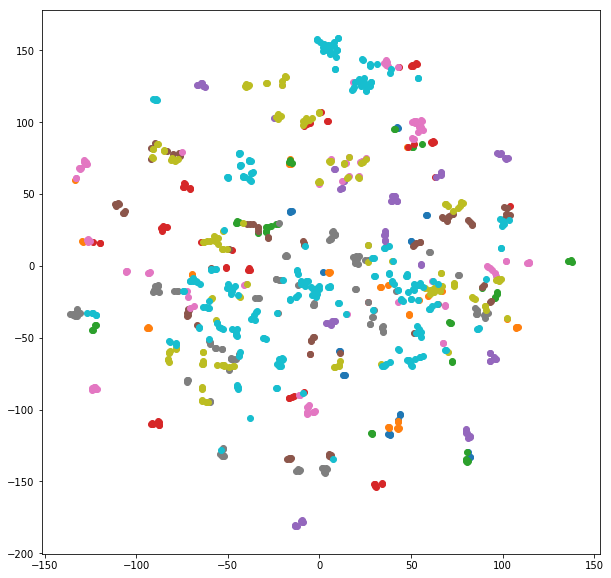

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.tab10(np.linspace(0, 1, CLUSTER_NUM))

clusters = [ embeddings_2d[km_clusters == idx] for idx in range(CLUSTER_NUM) ]
clusters = sorted(clusters, key=len)

fig = plt.figure(figsize=(10, 10))

for idx, c in enumerate(clusters):
  x = c[:, 0]
  y = c[:, 1]
  plt.scatter(x, y, s=36, color=colors[idx])

plt.show()

In [8]:
import pandas as pd 

clustered_filenames = [ np.array(filenames)[km_clusters == idx] for idx in range(CLUSTER_NUM) ]

# Sort by cluster size
clustered_filenames = sorted(clustered_filenames, key=len)

def to_barcode(filename):
  return filename[filename.rindex('/') + 1: -4]

# Write to CSV
rows = []
for idx, cluster in enumerate(clustered_filenames):
  for filename in cluster:
    barcode = to_barcode(filename)
    rows.append([ idx, barcode, f'http://data.onb.ac.at/ABO/+{barcode}' ])

df = pd.DataFrame(rows, columns=['cluster', 'barcode', 'abo_url'])
df.to_csv('results.csv', index=False)
df

,cluster,barcode,abo_url
0,0,Z97793303,http://data.onb.ac.at/ABO/+Z97793303
1,1,Z9779440X,http://data.onb.ac.at/ABO/+Z9779440X
2,1,Z15517970X,http://data.onb.ac.at/ABO/+Z15517970X
3,2,Z148208904,http://data.onb.ac.at/ABO/+Z148208904
4,2,Z180696004,http://data.onb.ac.at/ABO/+Z180696004
5,3,Z124976809,http://data.onb.ac.at/ABO/+Z124976809
6,3,Z157772504,http://data.onb.ac.at/ABO/+Z157772504
7,4,Z203131903,http://data.onb.ac.at/ABO/+Z203131903
8,4,Z176509603,http://data.onb.ac.at/ABO/+Z176509603
9,4,Z204829604,http://data.onb.ac.at/ABO/+Z204829604
